In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import os
import json
from typing import Tuple
from tqdm import tqdm
from model_analysis.model_utils import *
from sklearn.metrics import mean_absolute_error

sns.set(rc={"figure.figsize": (20, 10)})


In [2]:
PATH_TO_DATA = "analysis/data/"
FEATURES_TO_USE = json.load(open("model_analysis/selected_features.json", "r"))
REPETITIONS = 10
MODELS_TO_EVALUATE = MODELS.keys()

In [3]:
def df_to_train_data(df: pd.DataFrame) -> Tuple[np.array, np.array]:
    return df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), df.drop(columns=df.columns[:-1], axis=1)

def run_paredoes(index: int) -> pd.DataFrame:
    # Treinando em n-1 paredões para predizer o n-ésimo
    paredoes_df = {
        "repeticao": [],
        "paredao": [],
        "eliminado": [],
        "rejeicao": [],
        "model": [],
        "pred": [],
        "pred_pct": [],
        "mae": []
    }
    paredoes = len(os.listdir(PATH_TO_DATA))

    for model in tqdm(MODELS_TO_EVALUATE, desc="- Modelos analisados"):
        params = PARAMETERS[model]
        regressor_model = MODELS[model]
        features = FEATURES_TO_USE[model]

        for paredao in range(1, paredoes):
            regressor = regressor_model(**params)
            if NORMALIZE[model]:
                train_df, test_df, mean, std = get_train_test(paredao, features, normalize=True, data_path=PATH_TO_DATA)
            else:
                train_df, test_df = get_train_test(paredao, normalize=False, features=features,  data_path=PATH_TO_DATA)

            x_train, y_train = df_to_train_data(train_df)
            x_test, y_test = df_to_train_data(test_df)

            y_train, y_test = np.ravel(y_train), np.ravel(y_test)

            regressor.fit(x_train, y_train)
            prediction = regressor.predict(x_test)

            paredoes_df["mae"].append(mean_absolute_error(y_test, prediction))

            if NORMALIZE[model]:
                test_df["predicao"] = prediction * std + mean
                test_df["rejeicao"] =  test_df["rejeicao"] * std + mean
            else:
                test_df["predicao"] = prediction
            
            pred_elimination, pred_pct = test_df.sort_values(by="predicao", ascending=False)[["nome", "predicao"]].iloc[0] 
            true_elimination, true_pct = test_df.sort_values(by="rejeicao", ascending=False)[["nome", "rejeicao"]].iloc[0]
            
            # renaming for consitence
            model_name = "ensamble1" if model == "ada_boost" else model 

            paredoes_df["repeticao"].append(index)
            paredoes_df["paredao"].append(paredao)
            paredoes_df["eliminado"].append(true_elimination)
            paredoes_df["rejeicao"].append(true_pct)
            paredoes_df["model"].append(model_name)
            paredoes_df["pred"].append(pred_elimination)
            paredoes_df["pred_pct"].append(pred_pct)
    
    return pd.DataFrame(paredoes_df)

In [4]:
paredoes_analysis_df = run_paredoes(0)
for index in range(1, REPETITIONS): paredoes_analysis_df = paredoes_analysis_df.append(run_paredoes(index), ignore_index=True)

- Modelos analisados: 100%|██████████| 11/11 [00:48<00:00,  4.40s/it]


In [5]:
paredoes_analysis_df.head()

,repeticao,paredao,eliminado,rejeicao,model,pred,pred_pct,mae
0,0,1,lucas_chumbo,0.7594,linear_regression,lucas_chumbo,0.862085,0.200743
1,0,2,petrix,0.8027,linear_regression,petrix,0.994525,0.286061
2,0,3,hadson,0.7971,linear_regression,hadson,0.587603,0.166875
3,0,4,lucas,0.6262,linear_regression,lucas,0.455717,0.232369
4,0,5,bianca_andrade,0.5309,linear_regression,felipe_prior,0.311857,0.099554


# Contagem de acertos

In [6]:
paredoes_analysis_df["mean_absolute_error"] = abs(paredoes_analysis_df["rejeicao"] - paredoes_analysis_df["pred_pct"])
paredoes_analysis_df["correct"] = paredoes_analysis_df["eliminado"] == paredoes_analysis_df["pred"]

In [7]:
paredoes_analysis_df[paredoes_analysis_df["repeticao"] == 0]

,repeticao,paredao,eliminado,rejeicao,model,pred,pred_pct,mae,mean_absolute_error,correct
0,0,1,lucas_chumbo,0.7594,linear_regression,lucas_chumbo,0.862085,0.200743,0.102685,True
1,0,2,petrix,0.8027,linear_regression,petrix,0.994525,0.286061,0.191825,True
2,0,3,hadson,0.7971,linear_regression,hadson,0.587603,0.166875,0.209497,True
3,0,4,lucas,0.6262,linear_regression,lucas,0.455717,0.232369,0.170483,True
4,0,5,bianca_andrade,0.5309,linear_regression,felipe_prior,0.311857,0.099554,0.219043,False
...,...,...,...,...,...,...,...,...,...,...
182,0,13,flayslene,0.6300,ensamble2,flayslene,0.587002,0.068976,0.042998,True
183,0,14,gizelly_bicalho,0.5479,ensamble2,gizelly_bicalho,0.614583,0.069668,0.066683,True
184,0,15,ivy,0.7417,ensamble2,ivy,0.435114,0.266730,0.306586,True
185,0,16,mari,0.5416,ensamble2,mari,0.493838,0.048433,0.047762,True


In [8]:
paredoes_analysis_df.to_csv("paredoes.csv")

In [9]:
resultados_medios = paredoes_analysis_df.groupby(["model", "paredao"]).mean()
resultados_medios["average_hits"] = paredoes_analysis_df[["model", "paredao", "correct"]].groupby(["model", "paredao"]).sum().values
resultados_medios.drop(["repeticao", "rejeicao"], axis=1, inplace=True)
resultados_medios.reset_index(inplace=True)


In [10]:
resultados_medios

,model,paredao,pred_pct,mae,mean_absolute_error,correct,average_hits
0,elastic_net,1,0.398654,0.232023,0.360746,1.0,10.0
1,elastic_net,2,0.401393,0.322615,0.401307,1.0,10.0
2,elastic_net,3,0.329599,0.333920,0.467501,1.0,10.0
3,elastic_net,4,0.403705,0.248783,0.222495,1.0,10.0
4,elastic_net,5,0.351693,0.156788,0.179207,0.0,0.0
...,...,...,...,...,...,...,...
182,svr,13,0.567151,0.065812,0.062849,1.0,10.0
183,svr,14,0.585637,0.052933,0.037737,1.0,10.0
184,svr,15,0.442289,0.257455,0.299411,1.0,10.0
185,svr,16,0.480419,0.062867,0.061181,1.0,10.0


In [11]:
acertos_medios = resultados_medios[["model", "average_hits"]].groupby("model").sum()
acertos_medios /= REPETITIONS

In [12]:
acertos_medios.sort_values(by="average_hits", ascending=False)

,average_hits
model,
ensamble3,16.0
svr,14.0
random_forest,13.6
ensamble2,13.4
ensamble1,13.0
knn,13.0
ridge,13.0
sgd,12.9
linear_regression,12.0


In [13]:
acertos_medios.sort_values(by="average_hits", inplace=True)

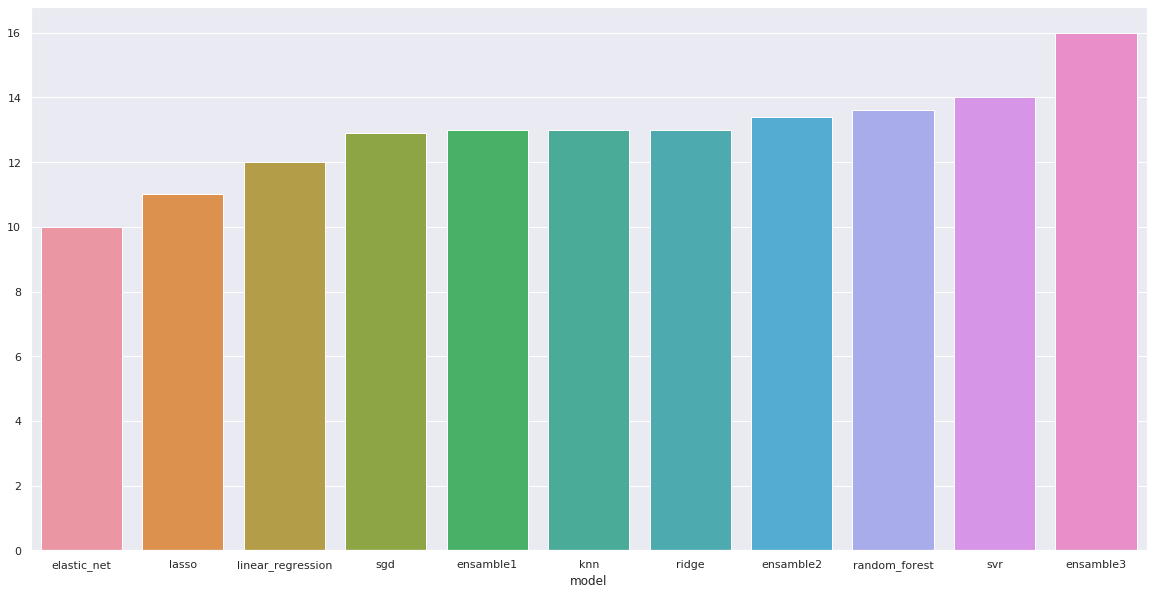

In [14]:
sns.barplot(x=acertos_medios.index, y=acertos_medios["average_hits"].values)

# Análise de erro absoluto por paredão

In [15]:
resultados_medios.sort_values(by="paredao", inplace=True)
erro_df = resultados_medios.set_index("paredao").pivot(columns="model")


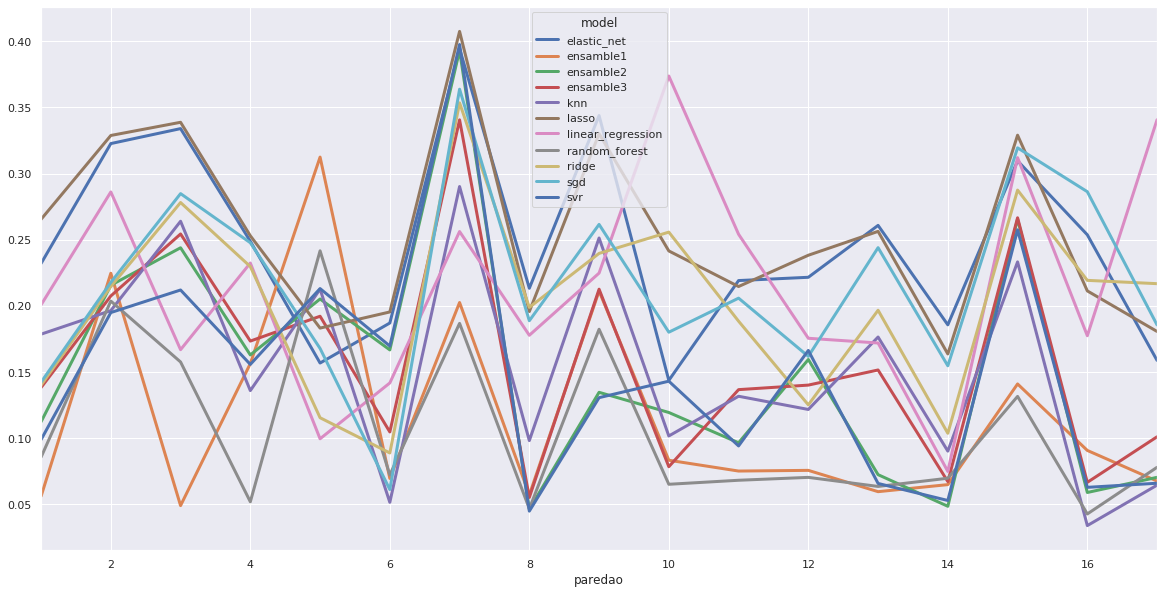

In [16]:
erro_df["mae"].plot(linewidth=3)

# Acertos em cada paredão

In [17]:
paredoes_analysis_df.head()

,repeticao,paredao,eliminado,rejeicao,model,pred,pred_pct,mae,mean_absolute_error,correct
0,0,1,lucas_chumbo,0.7594,linear_regression,lucas_chumbo,0.862085,0.200743,0.102685,True
1,0,2,petrix,0.8027,linear_regression,petrix,0.994525,0.286061,0.191825,True
2,0,3,hadson,0.7971,linear_regression,hadson,0.587603,0.166875,0.209497,True
3,0,4,lucas,0.6262,linear_regression,lucas,0.455717,0.232369,0.170483,True
4,0,5,bianca_andrade,0.5309,linear_regression,felipe_prior,0.311857,0.099554,0.219043,False


In [18]:
paredoes_df = paredoes_analysis_df[["paredao", "model", "correct"]].groupby(["paredao", "model"]).sum()

In [19]:
paredoes_df.reset_index(inplace=True)
paredoes_df = paredoes_df.groupby("paredao").mean()

In [20]:
paredoes_df

,correct
paredao,
1,10.000000
2,10.000000
3,10.000000
4,9.909091
5,0.000000
6,9.909091
7,6.272727
8,7.272727
9,10.000000


In [21]:
paredoes_df = paredoes_df.groupby("paredao").mean()
paredoes_df.sort_index(inplace=True, ascending=False)

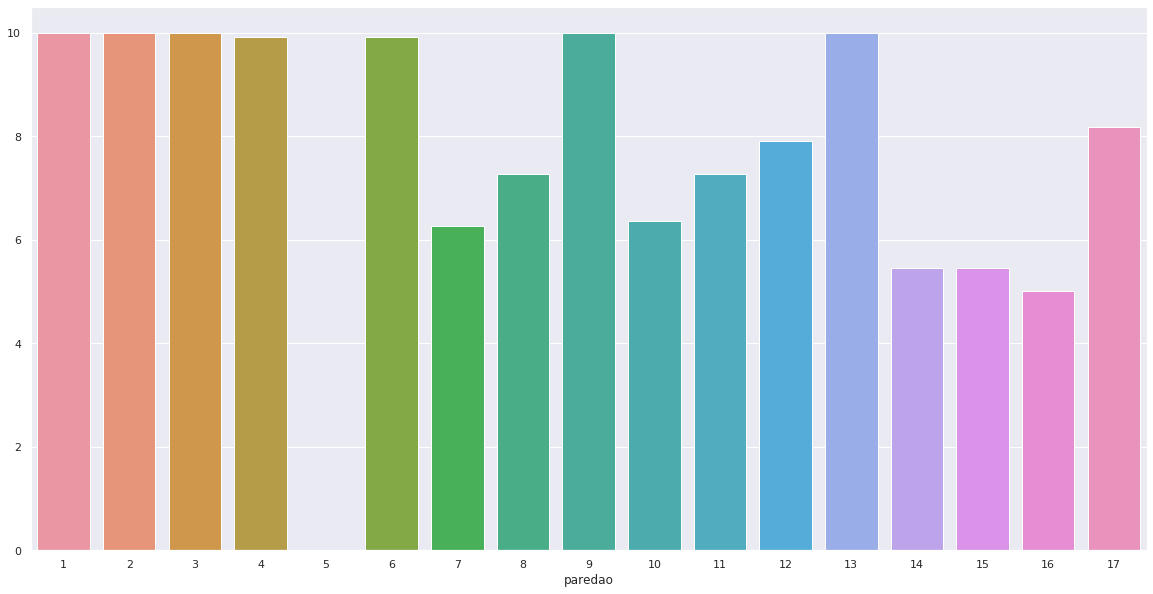

In [22]:
sns.barplot(x=paredoes_df.index, y=paredoes_df["correct"].values)